In [1]:
import numpy as np

In [2]:
class Layer:
    def __init__(self):
        self.input_data = None 
        self.output_data = None
        self.is_parameterized = False
    def forward(self,X):
        pass

    def predict(self,X):
        return self.forward(X)
    
    def compute_gradient(self,output_error):
        pass
    def apply_gradient(self,learning_rate,gradients=[]):
        pass
    def get_gradients(self):
        return []

    def backward(self,output_error):
        pass
        
    def get_regularization_weights(self):
        return []

    def get_regularization_gradients(self):
        return []

In [3]:
class Activation(Layer):
    def __init__(self):
        super().__init__()
        
    def activation(self, X):
        raise NotImplementedError("Function must be implemented in subclass")

    def d_activation(self, X):
        raise NotImplementedError("Function must be implemented in subclass")

    def apply_gradient(self,learning_rate,gradients=[]):
        pass

    def forward(self, X):
        self.input_data = X
        self.output_data = self.activation(X)  # This should correctly update output_data in child class
        return self.output_data

    def backward(self,output_error):
        return self.d_activation(self.input_data) * output_error

    def compute_gradient(self, output_error):
        input_error = self.d_activation(self.input_data) * output_error
        return {'input_error': input_error, 'gradients': []}

In [4]:
class Linear(Layer):
    def __init__(self,input_size,output_size,weight_initialization='he'):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size

        self.initialize_weights(weight_initialization)
        
        self.dW = np.ones(shape=(self.input_size,self.output_size))
        self.db = np.ones(shape=(1,self.output_size))

        self.is_parameterized = True

    def initialize_weights(self,init):
        if init == 'random':
            self.W = np.random.uniform(size=(self.input_size,self.output_size))-0.5
        elif init == 'xavier': #Good for tanh
            self.W = np.random.randn(self.input_size, self.output_size) * np.sqrt(1 / self.input_size)
        elif init == 'xavierV2': #Good for tanh
            self.W = np.random.randn(self.input_size, self.output_size) * np.sqrt(2 / (self.input_size+self.output_size))
        elif init == 'he': #Good for relu
            self.W = np.random.randn(self.input_size, self.output_size) * np.sqrt(2 / self.input_size)
        self.b = np.zeros((1,self.output_size))



    def forward(self,X):
        self.input_data = X
        self.output_data = np.dot(X,self.W) + self.b
        return self.output_data

    def get_gradients(self):
        return [self.dW,self.db]

    def compute_gradient(self,output_error):
        self.dW = np.dot(self.input_data.transpose(),output_error)
        self.db = np.sum(output_error,axis=0).reshape(1,self.output_data.shape[1])
        input_error = np.dot(output_error,self.W.transpose()) 
        return {"input_error" : input_error, "gradients" : [self.dW,self.db]}

    def backward(self,output_error):
        self.dW = np.dot(self.input_data.transpose(),output_error)
        self.db = np.sum(output_error,axis=0).reshape(1,self.output_data.shape[1])
        return np.dot(output_error,self.W.transpose()) 

    def get_regularization_weights(self):
        return [self.W]

    def get_regularization_gradients(self):
        return [self.dW]

    def apply_gradient(self,learning_rate,gradients):
        dW = gradients[0]
        db = gradients[1]
        self.W = self.W - (learning_rate*dW)
        self.b = self.b - (learning_rate*db)

In [5]:
class Dropout(Layer):
    def __init__(self,keep_probability=0.5):
        super().__init__()
        self.keep_probability = keep_probability
        self.D = None

    def forward(self,X):
        self.D = np.random.uniform(size=X.shape) < self.keep_probability
        out = (X*self.D)/self.keep_probability
        return out

    def backward(self,output_error):
        return self.D*output_error
        
        
    def compute_gradient(self,output_error):
        input_error = self.D * output_error
        return {'input_error': input_error, 'gradients': []}

    def predict(self,X):
        return X

In [6]:
class ReLU(Activation):
    def __init__(self):
        super().__init__()
        
    def activation(self,X):
        return X*(X>0)

    def d_activation(self,X):
        return (X>0).astype(int)

In [7]:
class Sigmoid(Activation):        
    def __init__(self):
        super().__init__()
        
    def activation(self, X):
        return 1 / (1 + np.exp(-X))

    def d_activation(self, X):
        s = self.output_data
        return s * (1 - s)

In [8]:
class Tanh(Activation):
    def __init__(self):
        super().__init__()
        
    def activation(self,X):
        return np.tanh(X)
        
    def d_activation(self,X):
        t = self.output_data
        return  1. -(t**2)

In [9]:
class NeuralNetwork:
    def __init__(self,layers):
        self.layers = layers

    def forward(self,X):
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def predict(self,X):
        output = X
        for layer in self.layers:
            output = layer.predict(output)
        return output

In [10]:
class Regularization:
    def __init__(self,lambd = 0.01):
        self.lambd = lambd
    def get_weight_penalty(self,W,n):
        raise NotImplementedError("Function must be implemented in subclass")
    def get_weight_gradient(self,W,n):
        raise NotImplementedError("Function must be implemented in subclass")

In [11]:
class ZeroRegularization(Regularization):
    def __init__(self,lambd = 0.01):
        super().__init__(lambd)
    def get_weight_penalty(self,W,n):
        return 0
    def get_weight_gradient(self,W,n):
        return np.zeros_like(W)

In [12]:
class L2Regularization(Regularization):
    def __init__(self,lambd = 0.01):
        super().__init__(lambd)
    def get_weight_penalty(self,W,n):
        return (self.lambd/(2*n))*np.sum(W**2)
    def get_weight_gradient(self,W,n):
        return (self.lambd/n)*W

In [13]:
class L1Regularization(Regularization):
    def __init__(self,lambd = 0.01):
        super().__init__(lambd)
    def get_weight_penalty(self,W,n):
        return  (self.lambd/n)*np.sum(np.abs(W))
    def get_weight_gradient(self,W,n):
        return (self.lambd/n)*((W>0).astype(int) - 0.5)*2

In [14]:
class Loss:
    def __init__(self,layers = None,regularization=ZeroRegularization()):
        self.layers = layers
        self.parameterized_layers = [l for l in layers if l.is_parameterized]
        self.regularization = regularization
        self.error = 0
        self.y_true = 0
        self.y_pred = 0

    def backwards(self):
        output_error = self.compute_gradient(self.y_true,self.y_pred)
        for i in range(len(self.layers)-1,-1,-1):
            layer = self.layers[i]
            output_error = layer.backward(output_error)
            
            layer_regularization_weights = layer.get_regularization_weights()
            layer_gradients = layer.get_regularization_gradients()
            for i in range(len(layer_regularization_weights)):
                layer_gradients[i] += self.regularization.get_weight_gradient(layer_regularization_weights[i],len(self.y_true))
    
    def compute_gradient(self,y_true,y_pred):
        pass
    
    def compute_loss(self,y_true,y_pred):
        pass
        
    def loss(self,y_true,y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.error = self.compute_loss(y_true,y_pred) 
        penalty = 0
        for layer in self.parameterized_layers:
            for weight in layer.get_regularization_weights():
                penalty += self.regularization.get_weight_penalty(weight,len(self.y_true))
        return self.error + penalty

In [15]:
class MSELoss(Loss):
    def __init__(self,layers = None,regularization=ZeroRegularization()):
        super().__init__(layers,regularization)
    def mse(self,y_true,y_pred):
        out = y_pred - y_true
        out = out**2
        return np.mean(out)
    def compute_gradient(self,y_true,y_pred):
        out = (2/len(y_true))*(y_pred-y_true)
        return out
    def compute_loss(self,y_true,y_pred):
        return self.mse(y_true,y_pred)

In [16]:
class CELoss(Loss):
    def __init__(self,layers = None,regularization=ZeroRegularization(),epsilon=1e-15):
        super().__init__(layers,regularization)
        self.epsilon = epsilon

    def _clip_probabilities(self, y_pred):
        return np.clip(y_pred, self.epsilon, 1 - self.epsilon)

    def compute_loss(self, y_true, y_pred):
        y_pred = self._clip_probabilities(y_pred)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def compute_gradient(self, y_true, y_pred):
        y_pred = self._clip_probabilities(y_pred)
        return (y_pred - y_true) / (y_pred * (1 - y_pred))

In [17]:
class Optimizer:
    def __init__(self,layers,lr=0.01):
        self.lr = lr
        self.layers = [l for l in layers if l.is_parameterized]
        self.final_gradients = {i:self.layers[i].get_gradients() for i in range(len(self.layers))}

    def calculate_final_gradients(self):
        raise NotImplementedError("Function must be implemented in subclass")

    def step(self):
        self.calculate_final_gradients()
        for i in range(0,len(self.layers)):
            self.layers[i].apply_gradient(self.lr,self.final_gradients[i])

In [18]:
class SimpleOptimizer(Optimizer):
    def __init__(self,layers,lr=0.01):
        super().__init__(layers,lr)

    def calculate_final_gradients(self):
        for i in range(len(self.layers)-1,-1,-1):
            self.final_gradients[i] = self.layers[i].get_gradients()

In [19]:
class RMSProp(Optimizer):
    def __init__(self,layers,lr=0.01,beta=0.9):
        super().__init__(layers,lr)
        self.beta = beta
        self.epsilon = 1e-8
        self.S_gradients = {i:self.layers[i].get_gradients() for i in range(len(self.layers))}
        
    def calculate_final_gradients(self):
        for i in range(len(self.layers)-1,-1,-1):
            gradients = self.layers[i].get_gradients()
            for j in range(len(gradients)):
                self.S_gradients[i][j] = self.beta*self.S_gradients[i][j] + (1-self.beta)*(gradients[j]**2)
                self.final_gradients[i][j] = gradients[j]/((np.sqrt(self.S_gradients[i][j])) + self.epsilon)

In [20]:
class Adam(Optimizer):
    def __init__(self,layers,lr=0.01,beta_s=0.99,beta_v=0.9):
        super().__init__(layers,lr)
        
        self.beta_s = beta_s
        self.beta_v = beta_v
        
        self.t = 0
        
        self.epsilon = 1e-8
        
        self.S_gradients = {i:self.layers[i].get_gradients() for i in range(len(self.layers))}
        self.V_gradients = {i:self.layers[i].get_gradients() for i in range(len(self.layers))}

        
    def calculate_final_gradients(self):
        self.t+=1
        for i in range(len(self.layers)-1,-1,-1):
            gradients = self.layers[i].get_gradients()
            for j in range(len(gradients)):
                
                self.S_gradients[i][j] = (self.beta_s*self.S_gradients[i][j]) + ((1-self.beta_s)*(gradients[j]**2))
                corrected_s = self.S_gradients[i][j]/(1-(self.beta_s**self.t))

                self.V_gradients[i][j] = (self.beta_v*self.V_gradients[i][j]) + ((1-self.beta_v)*gradients[j])
                corrected_v = self.V_gradients[i][j]/(1-(self.beta_v**self.t))

                self.final_gradients[i][j] = corrected_v/(np.sqrt(corrected_s) + self.epsilon)
        

<h3>Solving the Xor problem</h3>

In [21]:
X = np.array([[0,0],[1,1],[0,1],[1,0]])
y = np.array([0,0,1,1]).reshape(4,1)

<h4>Here we can see how Logistic Regression fails to solve the Xor Problem</h4>

In [22]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X,y.reshape(4,))
lr_pred = lr.predict(X)
print(lr_pred)

[0 0 0 0]


<h4>Now let's check our Neural Network</h4>

In [23]:
def train(model, X, y, optimizer, loss, epochs, print_every, batch_size=-1, return_losses=False, X_val=None, y_val=None):
    train_losses = [] 
    val_losses = [] 
    n = len(X)
    if batch_size == -1 or batch_size > n:
        batch_size = n
    num_batches = (n // batch_size)
    for e in range(epochs):
        epoch_loss = 0
        indices = np.arange(n)
        np.random.shuffle(indices)
        X_shuffled = X[indices].astype(float)
        y_shuffled = y[indices].astype(float)

        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            output = model.forward(X_batch)
            error = loss.loss(y_batch, output)
            epoch_loss += error

            loss.backwards()
            optimizer.step()

        epoch_loss = epoch_loss/(num_batches)
        train_losses.append(epoch_loss)

        if X_val is not None and y_val is not None:
            val_output = model.predict(X_val)
            val_error = loss.loss(y_val, val_output)
            val_losses.append(val_error)
            if (e+1) % print_every == 0:
                print("Epoch:", e+1, "\tTrain Loss:", np.round(epoch_loss, 5), "\tValidation Loss:", np.round(val_error, 5))
        else:
            if (e+1) % print_every == 0:
                print("Epoch:", e+1, "\tTrain Loss:", np.round(epoch_loss, 5))

    if return_losses:
        if X_val is not None and y_val is not None:
            return train_losses,val_losses
        else:
            return train_losses

In [24]:
layers = [Linear(2,16), 
          ReLU(),
          Linear(16,8) ,
          ReLU(),
          Linear(8,1) ,
          Sigmoid()]

NN = NeuralNetwork(layers=layers)
optim = Adam(NN.layers,lr=0.01)
loss = CELoss(NN.layers)

In [25]:
train(NN,X,y,optim,loss,2_000,200)

Epoch: 200 	Train Loss: 0.44798
Epoch: 400 	Train Loss: 0.35004
Epoch: 600 	Train Loss: 0.34726
Epoch: 800 	Train Loss: 0.34672
Epoch: 1000 	Train Loss: 0.34662
Epoch: 1200 	Train Loss: 0.34661
Epoch: 1400 	Train Loss: 0.34658
Epoch: 1600 	Train Loss: 0.34658
Epoch: 1800 	Train Loss: 0.34657
Epoch: 2000 	Train Loss: 0.34657


In [26]:
print("Prediction is : " , np.round(NN.predict(X).reshape(4,)).astype(int))
print("y is :          " , y.reshape(4,))

Prediction is :  [1 0 1 1]
y is :           [0 0 1 1]


<h3>Good Job!</h3>

<h3>SimpleOptimizer vs RMSPropOptimizer vs Adam</h3>

In [27]:
import pandas as pd
def check_optimizer(optimizer_class):
    layers = [Linear(2,16), 
          ReLU(),
          Linear(16,8) ,
          ReLU(),
          Linear(8,1) ,
          Sigmoid()]

    NN = NeuralNetwork(layers=layers)
    optim = optimizer_class(NN.layers,lr=0.01)
    loss = CELoss(NN.layers)
    losses = train(model=NN,X=X,y=y,optimizer=optim,loss=loss,epochs=1000,print_every=np.inf,batch_size=-1,return_losses=True)
    return losses

In [28]:
simple_losses = check_optimizer(SimpleOptimizer)
rmsprop_losses = check_optimizer(RMSProp)
adam_losses = check_optimizer(Adam)

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

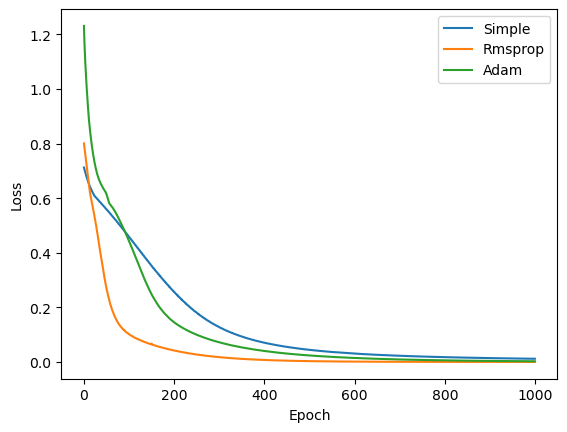

In [30]:
sns.lineplot(simple_losses,label='Simple')
sns.lineplot(rmsprop_losses,label='Rmsprop')
sns.lineplot(adam_losses,label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

<h3>We can see how the Models using RMSProp or Adam optimizers converge faster!</h3>

<h4>Verifying that the model works with multiple outputs (we simply expanded y to 2 classes)</h4>

In [31]:
X = np.array([[0,0],[1,1],[0,1],[1,0]])
y = np.array([[1,0],[1,0],[0,1],[0,1]])

In [32]:
def check_two_classes(loss_class):
    layers = [Linear(2,16), 
          Tanh(),
          Linear(16,8) ,
          Tanh(),
          Linear(8,2) ,
          Sigmoid()]

    NN = NeuralNetwork(layers=layers)
    optim = RMSProp(NN.layers,lr=0.1)
    loss = loss_class(NN.layers)
    train(NN,X,y,optim,loss,2_000,np.inf)
    print("Prediction is : \n" , np.round(NN.forward(X)).astype(int))

In [33]:
check_two_classes(MSELoss)

Prediction is : 
 [[1 0]
 [1 0]
 [0 1]
 [0 1]]


In [34]:
check_two_classes(CELoss)

Prediction is : 
 [[1 0]
 [1 0]
 [0 1]
 [0 1]]


<h1>Regularization Techniques</h1>

<h3>Importing regression data</h3>

In [35]:
import s3fs
import pandas as pd
data = pd.read_csv('house.csv')[['MSSubClass','LotFrontage','LotArea','PoolArea','MoSold','YrSold','SalePrice']].dropna()

for col in data.columns:
    M = data[col].max()
    m = data[col].min()
    data[col] = (data[col]-m)/(M-m)

X = data.drop('SalePrice',axis=1).values
y = data['SalePrice'].values
y = y.reshape((len(y),1))

train_size = int(len(X)*0.9)

X_train,X_val = X[:train_size],X[train_size:]
y_train,y_val = y[:train_size],y[train_size:]

In [36]:
X_train.shape,y_train.shape

((1080, 6), (1080, 1))

In [37]:
def train_model_and_plot_graph(NN,layers,loss):
    optim = Adam(NN.layers,lr=0.01)
    losses = train(model=NN,
               X=X_train,
               y=y_train,
               optimizer=optim,
               loss=loss,
               epochs=2500,
               print_every=500,
               batch_size=-1,
               return_losses=True,
               X_val=X_val,
               y_val=y_val)
    train_loss = losses[0]
    val_loss = losses[1]
    train_loss_smoothed = pd.Series(train_loss[500:]).rolling(window=50).mean()
    val_loss_smoothed = pd.Series(val_loss[500:]).rolling(window=50).mean()    
    sns.lineplot(data=train_loss_smoothed, label='Train Loss (Smoothed)')
    sns.lineplot(data=val_loss_smoothed, label='Validation Loss (Smoothed)')
    plt.show()
    print("-------------------------")
    print("Validation error : " , np.sqrt(np.mean((NN.predict(X_val)-y_val)**2)))

Epoch: 500 	Train Loss: 0.01337 	Validation Loss: 0.00963
Epoch: 1000 	Train Loss: 0.01107 	Validation Loss: 0.00932
Epoch: 1500 	Train Loss: 0.00707 	Validation Loss: 0.00996
Epoch: 2000 	Train Loss: 0.00484 	Validation Loss: 0.00963
Epoch: 2500 	Train Loss: 0.00442 	Validation Loss: 0.01035


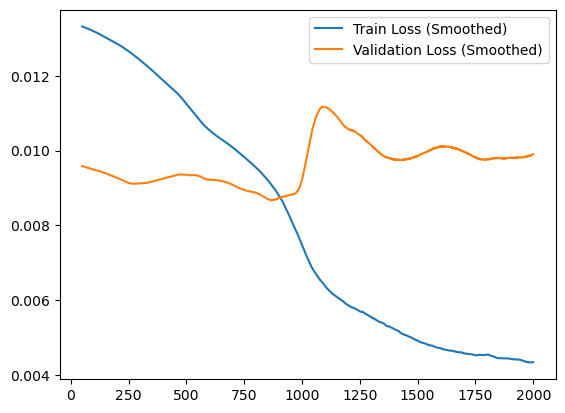

-------------------------
Validation error :  0.10171563996736926


In [38]:
layers = [Linear(6,32), 
          ReLU(),
          Linear(32,16) ,
          ReLU(),
          Linear(16,16) ,
          ReLU(),
          Linear(16,1)]
NN = NeuralNetwork(layers=layers)
loss = MSELoss(NN.layers)
train_model_and_plot_graph(NN,layers,loss)

<h3>We clearly see in this graph above a case of overfitting</h3>

Epoch: 500 	Train Loss: 0.01525 	Validation Loss: 0.0095
Epoch: 1000 	Train Loss: 0.01382 	Validation Loss: 0.00968
Epoch: 1500 	Train Loss: 0.01347 	Validation Loss: 0.00953
Epoch: 2000 	Train Loss: 0.01162 	Validation Loss: 0.00933
Epoch: 2500 	Train Loss: 0.01053 	Validation Loss: 0.00995


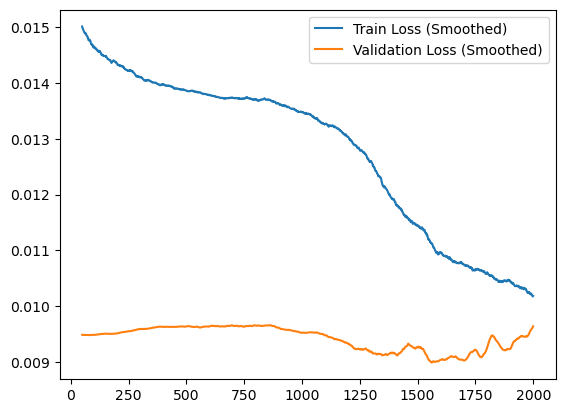

-------------------------
Validation error :  0.09975891366915023


In [39]:
layers = [Linear(6,32), 
          ReLU(),
          Dropout(0.5),
          Linear(32,16) ,
          ReLU(),
          Dropout(0.5),
          Linear(16,16) ,
          ReLU(),
          Linear(16,1)]
NN = NeuralNetwork(layers=layers)
loss = MSELoss(NN.layers)
train_model_and_plot_graph(NN,layers,loss)

<h3>Big Improvement from the last model</h3>

Epoch: 500 	Train Loss: 0.0157 	Validation Loss: 0.03581
Epoch: 1000 	Train Loss: 0.01243 	Validation Loss: 0.03542
Epoch: 1500 	Train Loss: 0.00917 	Validation Loss: 0.03357
Epoch: 2000 	Train Loss: 0.00674 	Validation Loss: 0.02455
Epoch: 2500 	Train Loss: 0.0062 	Validation Loss: 0.02596


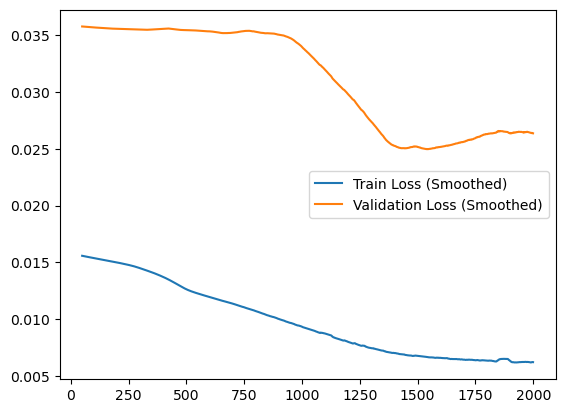

-------------------------
Validation error :  0.10794510153649944


In [40]:
layers = [Linear(6,32), 
          ReLU(),
          Linear(32,16) ,
          ReLU(),
          Linear(16,16) ,
          ReLU(),
          Linear(16,1)]
NN = NeuralNetwork(layers=layers)
loss = MSELoss(NN.layers,L2Regularization(lambd=0.05))
train_model_and_plot_graph(NN,layers,loss)

Epoch: 500 	Train Loss: 0.02556 	Validation Loss: 0.1179
Epoch: 1000 	Train Loss: 0.02423 	Validation Loss: 0.11302
Epoch: 1500 	Train Loss: 0.01573 	Validation Loss: 0.07336
Epoch: 2000 	Train Loss: 0.01021 	Validation Loss: 0.03418
Epoch: 2500 	Train Loss: 0.00889 	Validation Loss: 0.03163


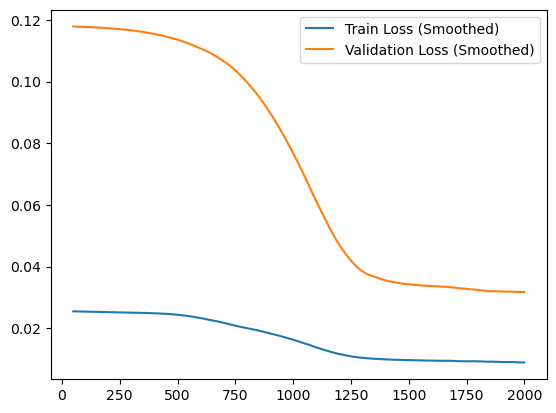

-------------------------
Validation error :  0.09629706147905152


In [41]:
layers = [Linear(6,32), 
          ReLU(),
          Linear(32,16) ,
          ReLU(),
          Linear(16,16) ,
          ReLU(),
          Linear(16,1)]
NN = NeuralNetwork(layers=layers)
loss = MSELoss(NN.layers,L1Regularization(lambd=0.05))
train_model_and_plot_graph(NN,layers,loss)

<h3>Regularization actually solved the overfitting problem, both the L1 and L2 and the Dropout</h3>

<h2>Comparing to LinearRegression</h2>

In [42]:
def error(y_true,y_pred):
    return np.sqrt(np.sum((y_true-y_pred)**2))

In [43]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,y.reshape(len(y),))
lr_pred = lr.predict(X_val)
lr_error = error(lr_pred.flatten(),y_val.flatten())

In [44]:
layers = [Linear(6,32), 
          ReLU(),
          Linear(32,16) ,
          ReLU(),
          Linear(16,16) ,
          ReLU(),
          Linear(16,1)]
NN = NeuralNetwork(layers=layers)
optim = RMSProp(NN.layers,lr=0.001)
loss = MSELoss(NN.layers,L1Regularization(lambd=0.05))

In [45]:
train(model=NN,
               X=X_train,
               y=y_train,
               optimizer=optim,
               loss=loss,
               epochs=15_000,
               print_every=1000,
               batch_size=len(X_train)//5)

Epoch: 1000 	Train Loss: 0.01716
Epoch: 2000 	Train Loss: 0.01573
Epoch: 3000 	Train Loss: 0.01556
Epoch: 4000 	Train Loss: 0.01522
Epoch: 5000 	Train Loss: 0.01549
Epoch: 6000 	Train Loss: 0.01519
Epoch: 7000 	Train Loss: 0.01578
Epoch: 8000 	Train Loss: 0.01537
Epoch: 9000 	Train Loss: 0.01517
Epoch: 10000 	Train Loss: 0.01546
Epoch: 11000 	Train Loss: 0.01534
Epoch: 12000 	Train Loss: 0.01564
Epoch: 13000 	Train Loss: 0.0152
Epoch: 14000 	Train Loss: 0.0152
Epoch: 15000 	Train Loss: 0.01575


In [46]:
nn_pred = NN.predict(X_val)
nn_error = error(nn_pred.flatten(),y_val.flatten())

<h3>We can see here how the NeuralNetwork with regularization outperformed the LinearRegression</h3>

In [47]:
print("Linear regression error : " , lr_error)
print("Neural Network error    : " , nn_error)

Linear regression error :  1.00124229139492
Neural Network error    :  0.9707846445679541
